In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle
from scipy.stats import *
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from circ_stats import *
import scipy.stats as sts
import matplotlib.pylab as pylab
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

In [2]:
import matplotlib.pyplot as plt
plt.style.use("nature_neurosci.mplstyle")


# Define colors
colors = {
    "Single": "#333333",
    "Left": "#246EB9",
    "Right": "#8B1E3F",
    "Ipsilateral": "#1B9E77",
    "Contralateral": "#D95F02",
    "Within": "#2B4162",
    "Across": "#E89D0B",
    'SerialBias': '#44ac8d31',\
    'SerialBiasWeak': '#b2b09bff'
}

from matplotlib.colors import LinearSegmentedColormap
left_right_cmap = LinearSegmentedColormap.from_list("LeftRight",\
                                                     [colors['Left'], "white", colors['Right']])
ipsi_contra_cmap = LinearSegmentedColormap.from_list("IpsiContra",\
                                                     [colors['Ipsilateral'], "white", colors['Contralateral']])

In [3]:
def Wimmer_FR(df = pd.DataFrame(), firing_type='n_delayFull'):
    df_grouped = df.groupby(['targ_angle'])
    # baseRF=np.mean(df[firing_type]) # mean FR for each neuron across targets
    targets = list(df_grouped.groups.keys())
    num_neurons = len(df[firing_type].values[0])
    receptive_fields = np.empty((len(targets), num_neurons), dtype=complex) * np.nan
    mean_count = np.empty((len(targets), num_neurons)) * np.nan
    for t, targ in enumerate(targets):  # for each target orientation
        # mean firing rate of each neuron for each target group, shape= (targets x neurons)
        receptive_fields[t, :] = np.mean(df_grouped.get_group(targ)[firing_type], axis=0)*np.exp(1j*targ)  # -baseRF)
        mean_count[t,:] = np.mean(df_grouped.get_group(targ)[firing_type], axis=0)

    rf_Wimmer = np.sum(receptive_fields, axis=0) / np.sum(mean_count, axis=0)
    theta_Wimmer = np.angle(rf_Wimmer)
    strength_Wimmer = np.abs(rf_Wimmer)
    return rf_Wimmer, theta_Wimmer, strength_Wimmer

def mov_avg(spike_matrix=[], w1=50, w2=250):
    m_err = []
    std_err = []
    x = np.arange(0, spike_matrix.shape[1], w1)
    for i, t in enumerate(x):
        idx = np.where((range(spike_matrix.shape[1])>(t-w2/2)) & (range(spike_matrix.shape[1])<(t+w2/2)))[0]
        # average over neurons, sum over time multiply to get in sp/s
        m_err.append(np.sum(np.mean(spike_matrix[:,idx], axis=0))*1000/w1)
        std_err.append(np.sum(np.mean(spike_matrix[:,idx], axis=0))*1000/w1)

    cut_defined = np.int(np.ceil(w1/w2))
    return (x[cut_defined:-cut_defined]), np.array(m_err)[cut_defined:-cut_defined], np.array(std_err)[cut_defined:-cut_defined]


def calc_receptiveFields(df = pd.DataFrame(), firing_type = 'n_delayFull', titel = ''):

    # COMPUTE TUNING CURVE FOR EACH NEURON

    # group by target position
    df_grouped = df.groupby(['targ_angle'])
    #baseRF=np.mean(df[firing_type']) # mean FR for each neuron across targets
    targets = list(df_grouped.groups.keys())
    num_neurons = len(df[firing_type].values[0])
    receptive_fields = np.empty((len(targets), num_neurons))*np.nan
    for t, targ in enumerate(targets):# for each target orientation
        # mean firing rate of each neuron for each target group, shape= (targets x neurons)
        group_activity = df_grouped.get_group(targ)[firing_type]
        receptive_fields[t, :] = np.mean(group_activity, axis=0)#-baseRF)

    # COMPUTE RECEPTIVE FIELD
    Wimmer_complex, Wimmer_rf, Wimmer_strength = Wimmer_FR(df = df, firing_type = firing_type)

    # fig, ax = plt.subplots(np.int(np.ceil(np.sqrt(num_neurons))), np.int(np.ceil(np.sqrt(num_neurons))), sharex=True, figsize=(15,15))
    # axes = np.concatenate(ax)

    max_rf = np.empty((num_neurons))*np.nan
    interpolated_rf = np.empty((num_neurons))*np.nan
    interpolated_strength = np.empty((num_neurons))*np.nan
    for neuron in range(num_neurons):
        # take RF curve for each neuron
        RF_neuron = receptive_fields[:,neuron]

        # save maximum of each RF curve as RF
        max_rf[neuron] = targets[np.argmax(RF_neuron)]

        # Perform interpolation to estimate the receptive field location
        interp_func = np.poly1d(np.polyfit(targets, RF_neuron, deg=4))  # Choose the degree of interpolation

        # Define a fine-grained angle range for interpolation
        xxx = np.linspace(np.min(targets), np.max(targets), 1000)

        # Find the maximum of the interpolated function
        max_idx = np.argmax(interp_func(xxx))
        interpolated_rf[neuron] = xxx[max_idx]
        interpolated_strength[neuron] = np.max(interp_func(xxx))

    return receptive_fields, max_rf, Wimmer_complex, Wimmer_rf, Wimmer_strength, interpolated_rf, interpolated_strength

In [4]:
def plot_bump(bump=[],ax=False,angle=0, cmap=left_right_cmap):

    x = np.arange(bump.shape[0])
    y = np.arange(bump.shape[1])

    x, y = np.meshgrid(x, y)
    
    if ax == False:
        ax = plt.figure().add_subplot(projection='3d')


    ax.plot_surface(x, y, bump.T, cmap=cmap,
                       linewidth=0) 
    # marker of stimulus location at end
    ax.plot((angle+np.pi)/(2*np.pi) * bump.shape[0], ax.get_ylim()[1], ax.get_zlim()[1]+ax.get_zlim()[1]/5,\
            'kv',ms=5)
   
    ax.set_axis_off()
    return

In [5]:
DATA_SMITH = '../../Desktop/PhD/2_Smith/Data/new/'

###############################################################
#                          LOAD DATA                          #
###############################################################

with open(DATA_SMITH + 'df_dat_correct.pickle', 'rb') as handle:
    df_dat_correct = pickle.load(handle)

with open(DATA_SMITH + 'leftRightIdx.pickle', 'rb') as handle:
    leftRightIdx = pickle.load(handle)

left_idx = {'Sa': [[] for i in range(len(leftRightIdx['left']['Sa']))],
            'Pe': [[] for i in range(len(leftRightIdx['left']['Pe']))],
            'Wa': [[] for i in range(len(leftRightIdx['left']['Wa']))]}
right_idx = {'Sa': [[] for i in range(len(leftRightIdx['left']['Sa']))],
             'Pe': [[] for i in range(len(leftRightIdx['left']['Pe']))],
             'Wa': [[] for i in range(len(leftRightIdx['left']['Wa']))]}
for m in ["Sa", "Pe", "Wa"]:
    for n in range(len(leftRightIdx['left'][m])):
        left_idx[m][n] = leftRightIdx['left'][m][n]
        right_idx[m][n] = leftRightIdx['right'][m][n]

df_dat_correct['hemifield'] = ['left' if (df_dat_correct['targ_angle'][i] < np.round(-np.pi / 2, 5)) | \
                                         (df_dat_correct['targ_angle'][i] > np.round(np.pi / 2, 5)) \
                                   else 'right' if (df_dat_correct['targ_angle'][i] > np.round(-np.pi / 2, 5)) & \
                                                   (df_dat_correct['targ_angle'][i] < np.round(np.pi / 2, 5)) \
                                  else 'border' \
                               for i in df_dat_correct.index]

print('loaded data')


loaded data


In [7]:
mono='Sa'
sess=0

df_mono = df_dat_correct.loc[(df_dat_correct['monkey'] == mono) & (df_dat_correct['session'] == sess)].copy().reset_index(drop=True)
df_mono['targ_angle'] = np.round(df_mono.targ_angle, 3)


targets = np.unique(df_mono.targ_angle)
try:
    assert (0 in targets), "We need one target to be centered at 0 for proper alignment."
except:
    print('Continuing with improper alignment')
    
num_neurons = len(left_idx[mono][sess][0])
hemi = ['left' if left_idx[mono][sess][0][i] == 1 else "right" for i in range(num_neurons)]


# PARAMETERS
bins, steps = 200, 10
min_stimstart = np.min(df_mono.targ_on)
min_stimstart = np.min(df_mono.targ_on)
min_delay_len = int(np.min(df_mono.delay)+np.min(df_mono.targ_off-df_mono.targ_on))
backdelay = 500

# smoothing across angles
bin_width = (2 * np.pi / len(targets)) / 2
# binned_statistics takes bin EDGES as input
angle_bins = np.arange(-np.max(targets) - bin_width, np.max(targets) + bin_width, bin_width * 2)
steps_neuron, width_neuron = (2*bin_width)/5, bin_width
smoothed_angles = np.arange(-np.pi, np.pi+steps_neuron, steps_neuron)

# HEMISPHERE DEF.
left = np.where(left_idx[mono][sess][0])[0]
right = np.where(right_idx[mono][sess][0])[0]

# delay average
# only determine memory tuning curves on average delay firing
delay_spiking = np.squeeze([np.sum(df_mono.loc[n, 'sp_train'][:, int(df_mono['targ_off'][n]):int(df_mono['go_cue'][n])], axis=1) * \
                1000 / (df_mono['go_cue'][n]-df_mono['targ_off'][n]) for n in df_mono.index])
df_mono['n_delayFull'] = list(delay_spiking) # all neurons during time of cue

# Example session

### bin data

In [16]:
min_resp2end = int(np.min(df_mono.trial_end-df_mono.saccade))

# moving average of spike counts from start to delay
smoothed_spiking_del = np.squeeze([[np.sum(df_mono.loc[trial, 'sp_train'][:,t:t+bins], axis=1)/bins\
                         for t in np.arange(df_mono.loc[trial,'targ_on']-min_stimstart,\
                                            df_mono.loc[trial,'targ_on']+min_delay_len-backdelay-bins, steps)]\
                                for trial in df_mono.index]).transpose(1,0,2)*1000

# moving average of spike counts from response to end
smoothed_spiking_resp = np.squeeze([[np.sum(df_mono.loc[trial, 'sp_train'][:, t:t + bins], axis=1) / bins \
                             for t in np.arange(df_mono.loc[trial,'saccade']-backdelay,\
                                                df_mono.loc[trial,'saccade']+min_resp2end - bins, steps)]\
                                 for trial in df_mono.index]).transpose(1,0,2)*1000

# combine stimulus and response aligned spiking activity
smoothed_spiking = np.append(smoothed_spiking_del, smoothed_spiking_resp, axis=0)

### correct for mean of each neuron (across time, neurons) 

In [17]:
# subtract mean across time, then across trials for each neuron
smoothed_corrected = smoothed_spiking - np.mean(smoothed_spiking, axis=(0,1))

# insert border for delay discontinuity (zeros) (after correction to not insert artificial things)
width_offset = 20
border = np.zeros((width_offset, smoothed_corrected.shape[1], smoothed_corrected.shape[2]))
smoothed_corrected = np.append(np.append(smoothed_corrected[:len(smoothed_spiking_del)+1], border, axis=0),\
                           smoothed_corrected[len(smoothed_spiking_del)+1:], axis=0)

trial_time = smoothed_corrected.shape[0]

### Crossvalidated receptive field computations

In [18]:
# initialize
Wimmer_rf_cross=[]
Wimmer_strength_cross=[]
pop_TCs = np.empty((len(df_mono.index), smoothed_corrected.shape[0], len(angle_bins) - 1))*np.nan
pop_TCs_smoothed = np.empty((len(df_mono.index), smoothed_corrected.shape[0], len(smoothed_angles)))*np.nan
pop_TCs_lr_smoothed = {'left': np.zeros((len(df_mono.index), smoothed_corrected.shape[0], len(smoothed_angles))), \
          'right': np.zeros((len(df_mono.index), smoothed_corrected.shape[0], len(smoothed_angles)))}
pop_TCs_ic_smoothed = {'ipsi': np.empty((len(df_mono.index), smoothed_corrected.shape[0], len(smoothed_angles) )) * np.nan, \
            'contra': np.empty((len(df_mono.index), smoothed_corrected.shape[0], len(smoothed_angles))) * np.nan}


# k-fold crossvalidation, stratify for target groups to have same target angle distributions in each subgroup
kf = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in kf.split(df_mono.index, df_mono.targ_angle.astype(str)):
    # create training and testing set, extract spiking as array
    df_train = df_mono.loc[train_idx]

    # calculate memory fields of neurons
    receptive_fields, max_rf, Wimmer_complex, Wimmer_rf, Wimmer_strength, interpolated_rf,\
        interpolated_strength = calc_receptiveFields(df = df_train, firing_type = 'n_delayFull',\
                                                     titel= mono+str(sess))

    Wimmer_rf_cross.append(Wimmer_rf)
    Wimmer_strength_cross.append(Wimmer_strength)
    
    # AVERAGE ACROSS NEURONS SORTED BY THEIR RECEPTIVE FIELDS (smoothing across neurons)
    binnedRFs = [np.where(abs(circdist(Wimmer_rf, angle_steps)) < (width_neuron/2))[0]\
                                    for angle_steps in smoothed_angles]

    for trial in test_idx:
        for times in range(smoothed_corrected.shape[0]):
            pop_TCs_smoothed[trial, times, :] = np.array([np.mean(smoothed_corrected[times, trial, b])\
                                                          for b in binnedRFs])

    # AVERAGE ACROSS NEURONS FOR IPSI VS CONTRA
    for lr in ['left', 'right']:
        binnedRFs_lr = [np.min(eval(lr))+np.where(abs(circdist(Wimmer_rf[eval(lr)], angle_steps)) < (width_neuron / 2))[0] \
                     for angle_steps in smoothed_angles]
        for trial in test_idx:
            for times in range(smoothed_corrected.shape[0]):
                pop_TCs_lr_smoothed[lr][trial, times, :] = np.array([np.mean(smoothed_corrected[times, trial, b]) \
                                                              for b in binnedRFs_lr])
                # save as ipsilateral/contralateral based on hemisphere
                if df_mono.hemifield[trial] == lr:
                    # pop_TCs_ic['ipsi'][trial, times, :] = bin_means
                    pop_TCs_ic_smoothed['ipsi'][trial, times, :] = np.array([np.mean(smoothed_corrected[times, trial, b]) \
                                                                    for b in binnedRFs_lr])
                elif (df_mono.hemifield[trial] != lr) & (df_mono.hemifield[trial] != 'border'):
                    # pop_TCs_ic['contra'][trial, times, :] = bin_means
                    pop_TCs_ic_smoothed['contra'][trial, times, :] = np.array([np.mean(smoothed_corrected[times, trial, b]) \
                                                                    for b in binnedRFs_lr])
                    
# average firing
Wimmer_rf_average = circmean(Wimmer_rf_cross, low=-np.pi, high=np.pi, axis=0)
Wimmer_strength_average = np.mean(Wimmer_strength_cross, axis=0)

assert np.all(np.isnan(pop_TCs_smoothed) == False), "After k-fold crossval, each trial must have a prediction."


### Figure 2c: average across stimulus groups (subtract stimulus location)

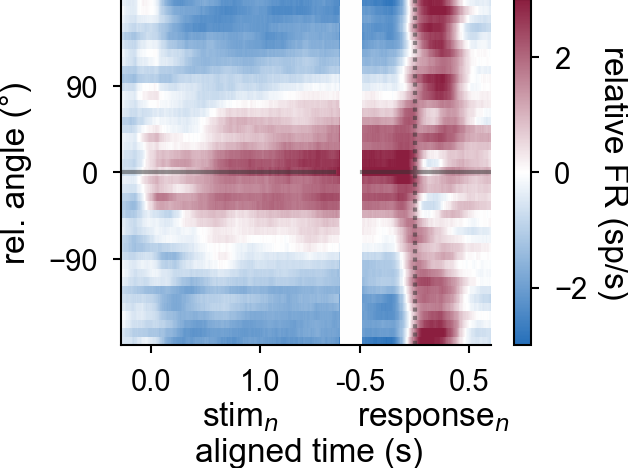

In [19]:
centered_pop_TCs_smoothed = np.empty((pop_TCs_smoothed.shape))*np.nan
for t, targ in enumerate(np.unique(df_mono.targ_angle)):
    chosen = df_mono.loc[df_mono.targ_angle == targ].index

    # shift bumps by location of cue appearence => center all bumps to 0
    indexof0 = np.argmin(abs(circdist(smoothed_angles, 0)))
    dist2cue = indexof0 - np.argmin(abs(circdist(smoothed_angles, targ)))
    centered_pop_TCs_smoothed[chosen, :, :] = np.roll(pop_TCs_smoothed[chosen], dist2cue, axis=2)


# PLOT average
f, ax = plt.subplots(figsize=(2.3, 1.6))
im = plt.imshow(np.mean(centered_pop_TCs_smoothed, axis=0).T, aspect='auto', \
                extent=[0, (trial_time * steps)/1000,
                        np.rad2deg(smoothed_angles[0]), np.rad2deg(smoothed_angles[-1])],
                origin='lower', interpolation='none', \
                cmap=left_right_cmap, vmin=-3, vmax=3)  # , vmin=-2.5, vmax=2.5, interpolation='none',
#plt.fill_between([min_stimstart, (min_stimstart+np.max(df_mono.targ_off - df_mono.targ_on))], \
#                 np.rad2deg(smoothed_angles[0]), np.rad2deg(smoothed_angles[-1]), alpha=0.3, color='#333333')
plt.axvline((min_delay_len+min_stimstart)/1000, color='#333333', alpha=0.5, dashes=[1,1])
plt.plot([0, (min_delay_len-backdelay+min_stimstart-width_offset*steps+steps-50)/1000], [0,0], color='#333333', alpha=0.5)
plt.plot([(min_delay_len-backdelay+min_stimstart+2*steps)/1000, (trial_time*steps)/1000], [0,0], color='#333333', alpha=0.5)
plt.ylabel('rel. angle (°)')
ticktimes = 1000
ticksDel = np.arange(min_stimstart, (min_delay_len-backdelay+min_stimstart-width_offset*steps), ticktimes)/1000
ticksResp = np.arange((min_delay_len-backdelay+min_stimstart), trial_time*steps, ticktimes)/1000
labelsfront = np.arange(0, min_delay_len-backdelay, ticktimes)/1000
labelsback = np.arange(-backdelay, min_resp2end, ticktimes)/1000
ax.set_xticks(np.append(ticksDel, ticksResp))
ax.set_xticklabels(np.append(labelsfront, labelsback))
cbar = plt.colorbar(im)
cbar.set_label('relative FR (sp/s)', rotation=270, verticalalignment='baseline')
plt.yticks([-90, 0, 90])
f.text(0.4, 0.015, 'stim$_n$', ha='center', fontsize=8)
f.text(0.68, 0.015, 'response$_n$', ha='center', fontsize=8)
f.text(0.5, -0.06, 'aligned time (s)', ha='center', fontsize=8)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()
#plt.savefig('./Figures/Figure2/AllTrials_firingrateBumps_Ownsmoothed_response.svg')
plt.show()

### Supplement: ipsi vs contra

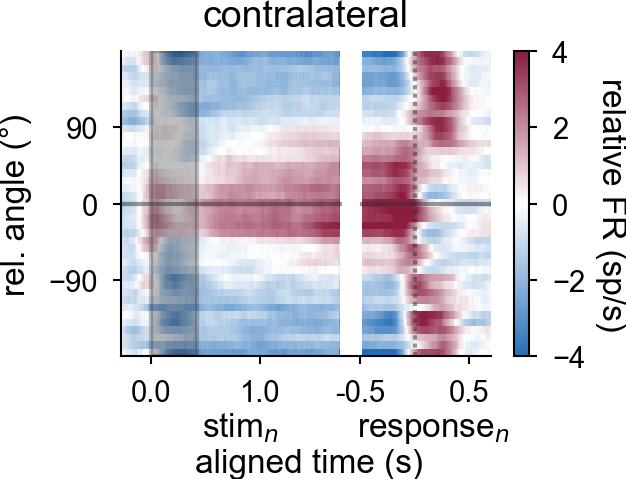

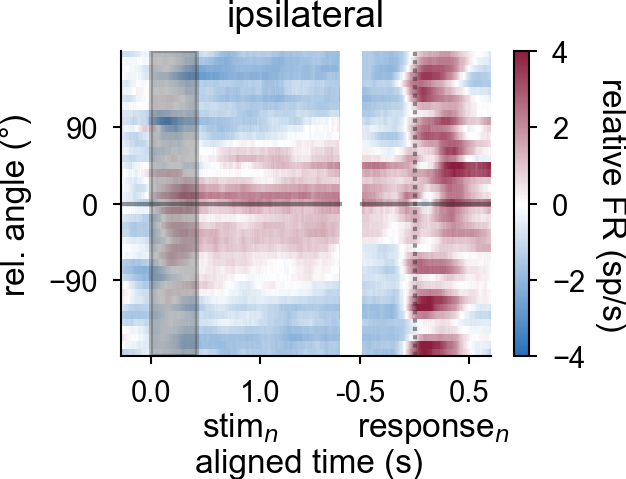

In [20]:
# PLOT AVERAGE ACROSS GROUPS: subtract stimulus presentation place (center at center)
#centered_IC = {'ipsi':np.empty((pop_TCs_ic['ipsi'].shape)) * np.nan, 'contra':np.empty((pop_TCs_ic['contra'].shape)) * np.nan}
centered_IC_smoothed = {'ipsi':np.empty((pop_TCs_ic_smoothed['ipsi'].shape)) * np.nan,\
                        'contra':np.empty((pop_TCs_ic_smoothed['contra'].shape)) * np.nan}
for hemi in ['ipsi', 'contra']:
    for t, targ in enumerate(np.unique(df_mono.targ_angle)):
        chosen = df_mono.loc[df_mono.targ_angle == targ].index

        # # subtract angle of cue appearence, center all bumps to 0
        # indexof0 = np.argmin(abs(circdist(bin_labels, 0)))
        # dist2cue = indexof0 - np.argmin(abs(circdist(bin_labels, targ)))
        # centered_IC[hemi][chosen, :, :] = np.roll(pop_TCs_ic[hemi][chosen], dist2cue, axis=2)

        indexof0 = np.argmin(abs(circdist(smoothed_angles, 0)))
        dist2cue = indexof0 - np.argmin(abs(circdist(smoothed_angles, targ)))
        centered_IC_smoothed[hemi][chosen, :, :] = np.roll(pop_TCs_ic_smoothed[hemi][chosen], dist2cue, axis=2)

# drop border trials
#centered_IC['ipsi'] = centered_IC['ipsi'][np.where(df_mono.hemifield!='border')[0]]
#centered_IC['contra'] = centered_IC['contra'][np.where(df_mono.hemifield!='border')[0]]
centered_IC_smoothed['ipsi'] = centered_IC_smoothed['ipsi'][np.where(df_mono.hemifield!='border')[0]]
centered_IC_smoothed['contra'] = centered_IC_smoothed['contra'][np.where(df_mono.hemifield!='border')[0]]


#im =  {'ipsi':[], 'contra':[], 'diff':[]}
#f, ax = plt.subplots(1, 3, figsize=(11.1, 2.3))
for h, hemi in enumerate(['contra', 'ipsi']):
    f, ax = plt.subplots(figsize=(2.3, 1.6))
    im = plt.imshow(np.nanmean(centered_IC_smoothed[hemi], axis=0).T, aspect='auto', \
                extent=[0, (trial_time * steps)/1000,
                        np.rad2deg(smoothed_angles[0]), np.rad2deg(smoothed_angles[-1])],
                origin='lower', interpolation='none', \
                cmap=left_right_cmap, vmin=-4, vmax=4)  # , vmin=-2.5, vmax=2.5, interpolation='none',

    plt.fill_between([min_stimstart/1000, (min_stimstart + np.max(df_mono.targ_off - df_mono.targ_on))/1000], \
                     np.rad2deg(smoothed_angles[0]), np.rad2deg(smoothed_angles[-1]), alpha=0.3, color='#333333')
    plt.axvline((min_delay_len + min_stimstart)/1000, color='#333333', alpha=0.5, dashes=[1,1])
    plt.plot([0, (min_delay_len - backdelay + min_stimstart - width_offset * steps + steps)/1000], [0, 0], color='#333333', alpha=0.5)
    plt.plot([(min_delay_len - backdelay + min_stimstart + 2 * steps)/1000, trial_time * steps/1000], [0, 0], color='#333333', alpha=0.5)
    plt.ylabel('rel. angle (°)')
    ticktimes = 1000
    ticksDel = np.arange(min_stimstart, (min_delay_len - backdelay + min_stimstart - width_offset * steps),
                         ticktimes)/1000
    ticksResp = np.arange((min_delay_len - backdelay + min_stimstart), trial_time * steps, ticktimes)/1000
    labelsfront = np.arange(0, min_delay_len - backdelay, ticktimes)/1000
    labelsback = np.arange(-backdelay, min_resp2end, ticktimes)/1000
    plt.xticks(np.append(ticksDel, ticksResp), np.append(labelsfront, labelsback))
    cbar = plt.colorbar(im)
    cbar.set_label('relative FR (sp/s)', rotation=270, verticalalignment='baseline')
    plt.yticks([-90, 0, 90])
    f.text(0.4, 0.015, 'stim$_n$', ha='center', fontsize=8)
    f.text(0.68, 0.015, 'response$_n$', ha='center', fontsize=8)
    f.text(0.5, -0.06, 'aligned time (s)', ha='center', fontsize=8)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.title(hemi+'lateral')
    plt.tight_layout()
    #plt.savefig('./Figures/Figure2/ICFiringrateBumps_'+hemi+'_responseRB.svg')
    plt.show()

### Figure 2a: plot example neuron

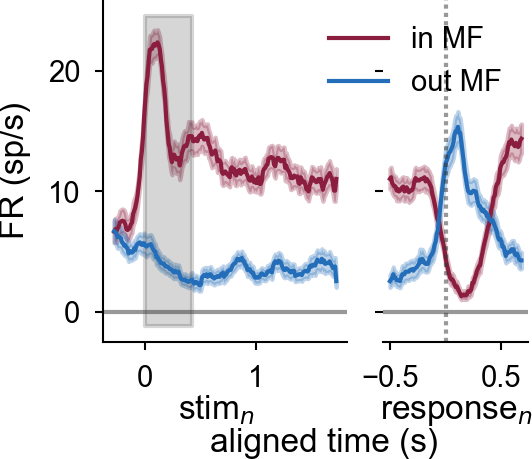

In [22]:
chosen_neuron = 148  # 12, 138, 7, 148, 108, 39, 6 # chose good neuron eg where Wimmer_strength is large

# determine  which stimulus is closest to receptive field of neuron
inRFangle = targets[np.argmin(np.abs([circdist(Wimmer_rf_average[chosen_neuron], targ) for targ in targets]))]
# distance of pi away from inRF
outRFangle = targets[np.argmin(np.abs([circdist(circdist(inRFangle, np.pi)[0], targ) for targ in targets]))]
# average spiking IN RF vs OUT RF trials
inRFidx = df_mono.loc[df_mono.targ_angle == inRFangle].index
outRFidx = df_mono.loc[df_mono.targ_angle == outRFangle].index
inRFspiking = smoothed_spiking[:, inRFidx, chosen_neuron]
outRFspiking = smoothed_spiking[:, outRFidx, chosen_neuron]

xx = [np.linspace(-min_stimstart, len(smoothed_spiking_del)*steps-min_stimstart, len(smoothed_spiking_del)+1)/1000,\
      np.linspace(-backdelay, len(smoothed_spiking_resp)*steps-backdelay-steps, len(smoothed_spiking_resp))/1000]
inSpiking = [inRFspiking[:len(smoothed_spiking_del)+1], inRFspiking[len(smoothed_spiking_del):]]
outSpiking = [outRFspiking[:len(smoothed_spiking_del)+1], outRFspiking[len(smoothed_spiking_del):]]
width_radius = [len(xx[0]), len(xx[1])]
f, ax = plt.subplots(1, 2, figsize=(2., 1.55), sharey='row', gridspec_kw={'width_ratios': width_radius})
for t in range(2):
    ax[t].axhline(0, color='#333333', alpha=0.5)
    ax[t].plot(xx[t], np.mean(inSpiking[t], axis=1), label='in MF', color=colors['Right'])
    ax[t].fill_between(xx[t], np.mean(inSpiking[t], axis=1) - sem(inSpiking[t], axis=1), \
                    np.mean(inSpiking[t], axis=1) + sem(inSpiking[t], axis=1), color=colors['Right'], alpha=0.3)
    ax[t].plot(xx[t], np.mean(outSpiking[t], axis=1), label='out MF', color=colors['Left'])
    ax[t].fill_between(xx[t], np.mean(outSpiking[t], axis=1) - sem(outSpiking[t], axis=1), \
                    np.mean(outSpiking[t], axis=1) + sem(outSpiking[t], axis=1), color=colors['Left'], alpha=0.3)
# mark stimulus
y0, y1 = ax[0].get_ylim()
ax[0].fill_between([0, np.max(df_mono['targ_off'] - df_mono['targ_on'])/1000], \
    y0, y1, alpha=0.2, color='#333333')
ax[1].axvline(0, color='#333333', alpha=0.5, dashes=[1,1])
f.text(0.42, 0.02, 'stim$_n$', ha='center', fontsize=8)
f.text(0.82, 0.02, 'response$_n$', ha='center', fontsize=8)
f.text(0.6, -0.05, 'aligned time (s)', ha='center', fontsize=8)
ax[0].set_ylabel('FR (sp/s)')
ax[1].legend()
sns.despine()
ax[0].xaxis.set_ticks_position('bottom')
ax[0].yaxis.set_ticks_position('left')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].spines['left'].set_visible(False)
ax[1].set_xticks([-0.5, 0.5])
plt.subplots_adjust(wspace=-1.5)
plt.tight_layout()
#plt.savefig('./Figures/Figure2/SingleNeuron_InVSOutRF_response.svg')
plt.show()

---

# Single trial analysis: Leave-one-out

In [8]:
min_delay_end = np.min(df_mono.trial_end)
# running avg over spike counts in each single trial
smoothed_spiking_singletrial = np.array([np.squeeze([np.sum(df_mono.loc[trial,'sp_train'][:, t:t + bins], axis=1)*\
                                            1000 / bins\
                                            for t in np.arange(0, min_delay_end-bins, steps)])\
                                for trial in df_mono.index]).transpose(1,0,2)

# subtract mean for each neuron (across time, then across trials)
smoothed_corrected_singletrial = smoothed_spiking_singletrial - np.mean(smoothed_spiking_singletrial, axis=(0,1))


In [9]:
#pop_TCs_loo = np.empty((len(df_mono.index), smoothed_corrected_singletrial.shape[0], len(angle_bins) - 1))*np.nan
pop_TCs_loo_smoothed = np.empty((len(df_mono.index), smoothed_corrected_singletrial.shape[0], len(smoothed_angles)))*np.nan
pop_TCs_loo_smoothed_left = np.empty((len(df_mono.index), smoothed_corrected_singletrial.shape[0], len(smoothed_angles)))*np.nan
pop_TCs_loo_smoothed_right = np.empty((len(df_mono.index), smoothed_corrected_singletrial.shape[0], len(smoothed_angles)))*np.nan
pop_TCs_loo_smoothed_ipsi = np.empty((len(df_mono.index), smoothed_corrected_singletrial.shape[0], len(smoothed_angles)))*np.nan
pop_TCs_loo_smoothed_contra = np.empty((len(df_mono.index), smoothed_corrected_singletrial.shape[0], len(smoothed_angles)))*np.nan
Wimmer_rf_cross_loo = []

loo = LeaveOneOut()
for train_idx, test_idx in loo.split(df_mono.index):
    # create training and testing set, extract spiking as array
    df_train = df_mono.loc[train_idx]
    test_idx = test_idx[0]

    # calculate memory fields of neurons
    receptive_fields, max_rf, Wimmer_complex, Wimmer_rf, Wimmer_strength, interpolated_rf,\
        interpolated_strength = calc_receptiveFields(df = df_train, firing_type = 'n_delayFull', titel= mono+str(sess))
    Wimmer_rf_cross_loo.append(Wimmer_rf)

    # get indices for each subsection of space where neurons have RF
    binnedRFs = [np.where(abs(circdist(Wimmer_rf, angle_steps)) < (width_neuron / 2))[0] \
                 for angle_steps in smoothed_angles]
    binnedRFs_left = [binnedRFs[i][binnedRFs[i] < np.min(right)] for i in range(len(binnedRFs))]
    binnedRFs_right = [binnedRFs[i][binnedRFs[i] > np.max(left)] for i in range(len(binnedRFs))]
    # AVERAGE ACROSS NEURONS SORTED BY THEIR RECEPTIVE FIELDS (smoothing across neurons)
    for times in range(smoothed_corrected_singletrial.shape[0]):
        pop_TCs_loo_smoothed[test_idx, times, :] = np.array([np.mean(smoothed_corrected_singletrial[times, test_idx, b])\
                                                          for b in binnedRFs])
        pop_TCs_loo_smoothed_left[test_idx, times, :] = np.array([np.mean(smoothed_corrected_singletrial[times, test_idx, b])\
                                                          for b in binnedRFs_left])
        pop_TCs_loo_smoothed_right[test_idx, times, :] = np.array([np.mean(smoothed_corrected_singletrial[times, test_idx, b])\
                                                          for b in binnedRFs_right])

Wimmer_rf_average_loo = circmean(Wimmer_rf_cross_loo, low=-np.pi, high=np.pi, axis=0)



###### Figure 2b: plot one example trial

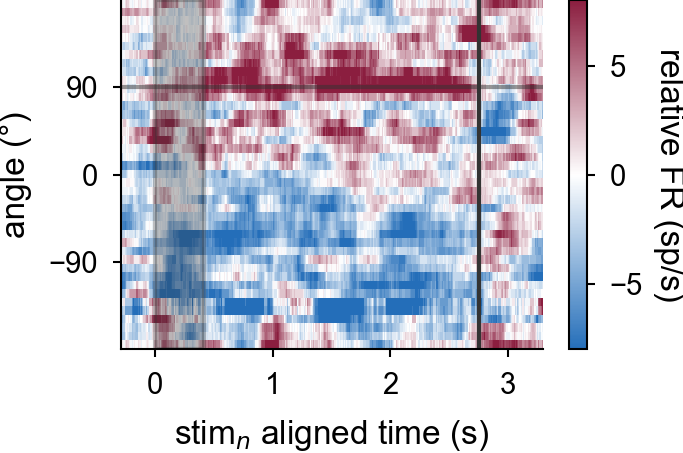

In [10]:
# ONE CHOSEN EXAMPLE TRIAL
chosen_angle = 1.571#2.356
chosen_trial = df_mono.loc[df_mono.targ_angle==chosen_angle].index[24]#24, 26, 60 #df_mono.loc[df_mono.targ_angle==chosen_angle].index[24]#24, 26, 60
trial_time = smoothed_corrected_singletrial.shape[0]

f, ax = plt.subplots(figsize=(2.5, 1.75))
im = plt.imshow(pop_TCs_loo_smoothed[chosen_trial].T, aspect='auto', \
                        extent=[-df_mono['targ_on'][chosen_trial] / 1000,\
                                (trial_time*steps -df_mono['targ_on'][chosen_trial])/1000,\
                                np.rad2deg(smoothed_angles[0]),
                                np.rad2deg(smoothed_angles[-1])],
                origin='lower', \
                cmap=left_right_cmap, vmin=-8, vmax=8, interpolation='none') # , vmin=-3, vmax=3, interpolation='none',
plt.axhline(np.rad2deg(chosen_angle), color='#333333', alpha=0.5)
plt.fill_between([0, (df_mono['targ_off'][chosen_trial]-df_mono['targ_on'][chosen_trial]) / 1000], \
                 np.rad2deg(smoothed_angles[0]), np.rad2deg(smoothed_angles[-1]), alpha=0.3, color='#333333')
plt.axvline((df_mono['saccade'][chosen_trial]-df_mono['targ_on'][chosen_trial])/1000, color='#333333')
#plt.axhline(np.rad2deg(df_mono.loc[chosen_trial, 'saccade_angle']), color='red', dashes=[5,5])
plt.ylabel('angle (°)')
plt.xlabel('stim$_n$ aligned time (s)')
plt.yticks([-90, 0, 90])
cbar = plt.colorbar(im)
cbar.set_label('relative FR (sp/s)', rotation=270, verticalalignment='baseline')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()
#plt.savefig('./Figures/Figure2/SingleTrial_firingrateBumps157_response.svg')
plt.show()

### Supplement: many example trials

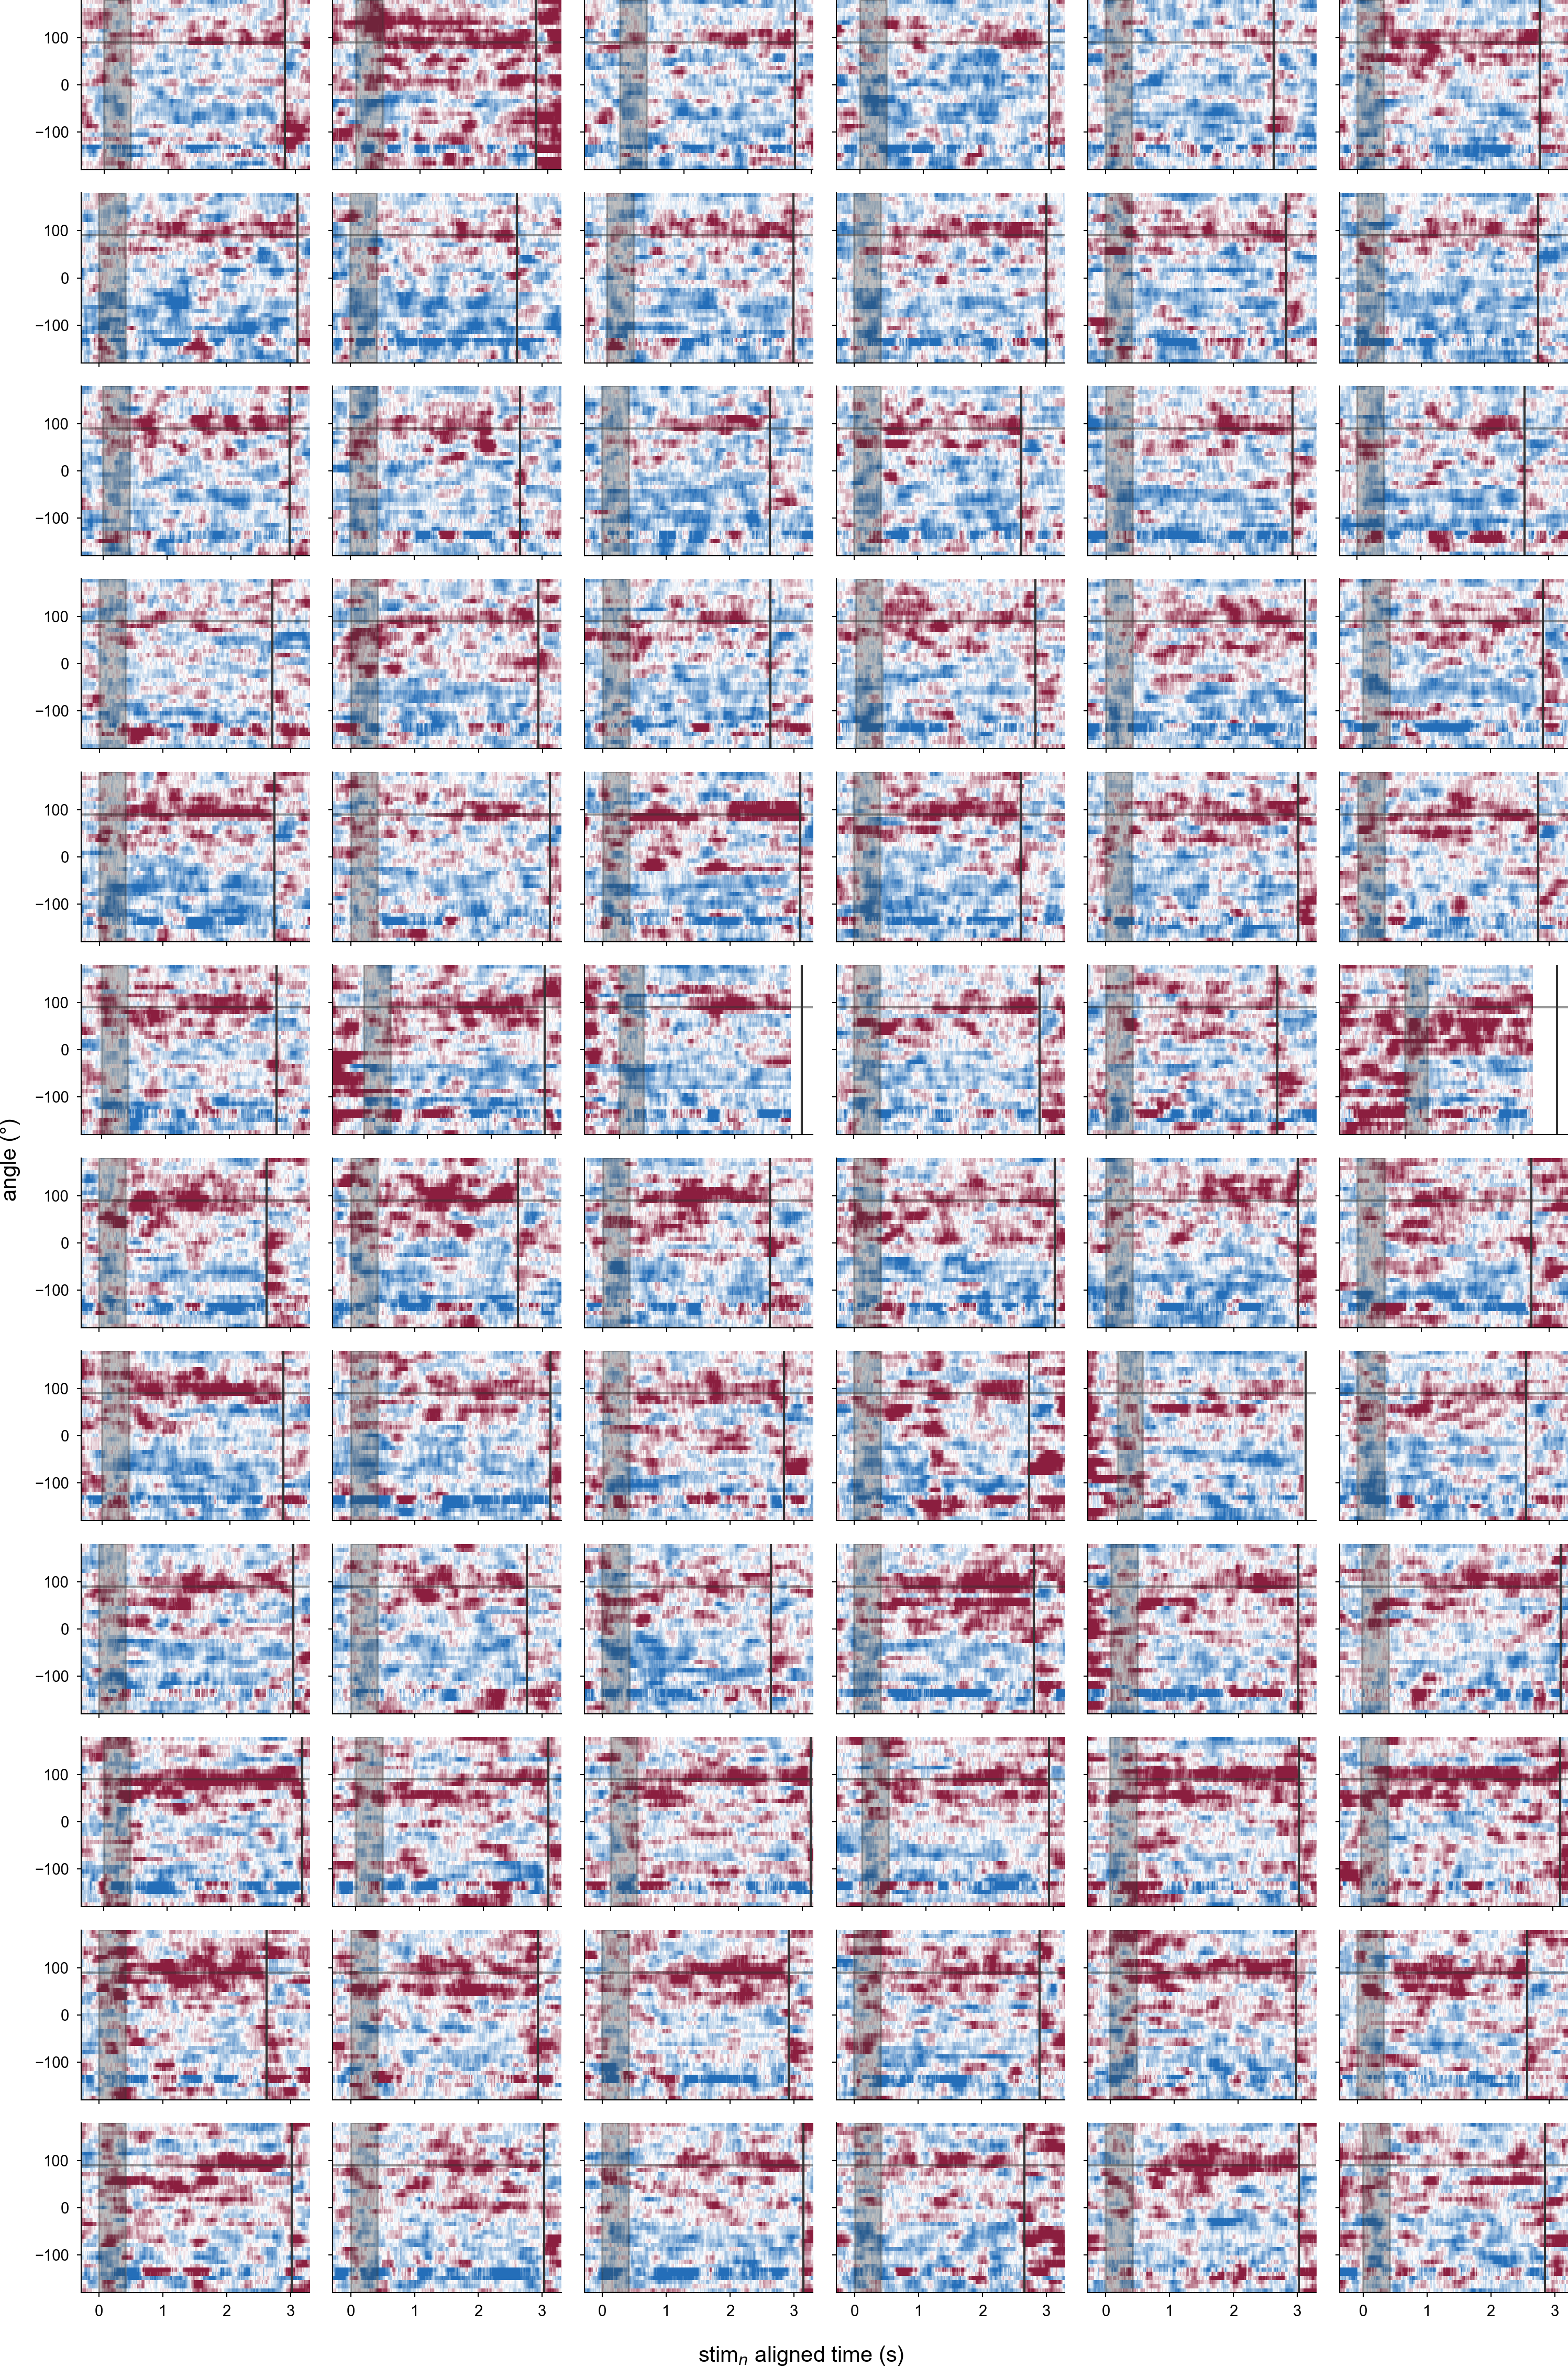

In [13]:
chosen_angle = 1.571#2.356
chosen_trials = df_mono.loc[df_mono.targ_angle==chosen_angle].index#
trial_time = smoothed_corrected_singletrial.shape[0]

f, ax = plt.subplots(np.int(np.ceil(np.sqrt(len(chosen_trials))))+3,\
                     np.int(np.ceil(np.sqrt(len(chosen_trials))))-3, figsize=(10, 15), sharey=True)
ax = np.concatenate(ax)

for c, chosen_trial in enumerate(chosen_trials):
    im = ax[c].imshow(pop_TCs_loo_smoothed[chosen_trial].T, aspect='auto', \
                            extent=[-df_mono['targ_on'][chosen_trial] / 1000,\
                                    (trial_time*steps -df_mono['targ_on'][chosen_trial])/1000,\
                                    np.rad2deg(smoothed_angles[0]),
                                    np.rad2deg(smoothed_angles[-1])],
                    origin='lower', \
                    cmap=left_right_cmap, vmin=-8, vmax=8, interpolation='none') # , vmin=-3, vmax=3, interpolation='none',
    ax[c].axhline(np.rad2deg(chosen_angle), color='#333333', alpha=0.5)
    ax[c].fill_between([0, (df_mono['targ_off'][chosen_trial]-df_mono['targ_on'][chosen_trial]) / 1000], \
                     np.rad2deg(smoothed_angles[0]), np.rad2deg(smoothed_angles[-1]), alpha=0.3, color='#333333')
    ax[c].axvline((df_mono['saccade'][chosen_trial]-df_mono['targ_on'][chosen_trial])/1000, color='#333333')
    ax[c].xaxis.set_ticks_position('bottom')
    ax[c].yaxis.set_ticks_position('left')
for axis in ax.flatten():
    if axis.is_first_col() == False:
        axis.tick_params(axis='y', which='both', labelleft=False)
    if axis.is_last_row() == False:
        axis.tick_params(axis='x', labelbottom=False)
f.text(0.5, -0.01, 'stim$_n$ aligned time (s)', ha='center', fontsize=10)
f.text(-0.01, 0.5, 'angle (°)', va='center', rotation='vertical', fontsize=10)
plt.subplots_adjust(hspace=0.0)
plt.tight_layout()
#plt.savefig('./Figures/Figure2/Supplementary_ManyTrial'+str(chosen_angle)+'.svg')
plt.show()

#### colorbar

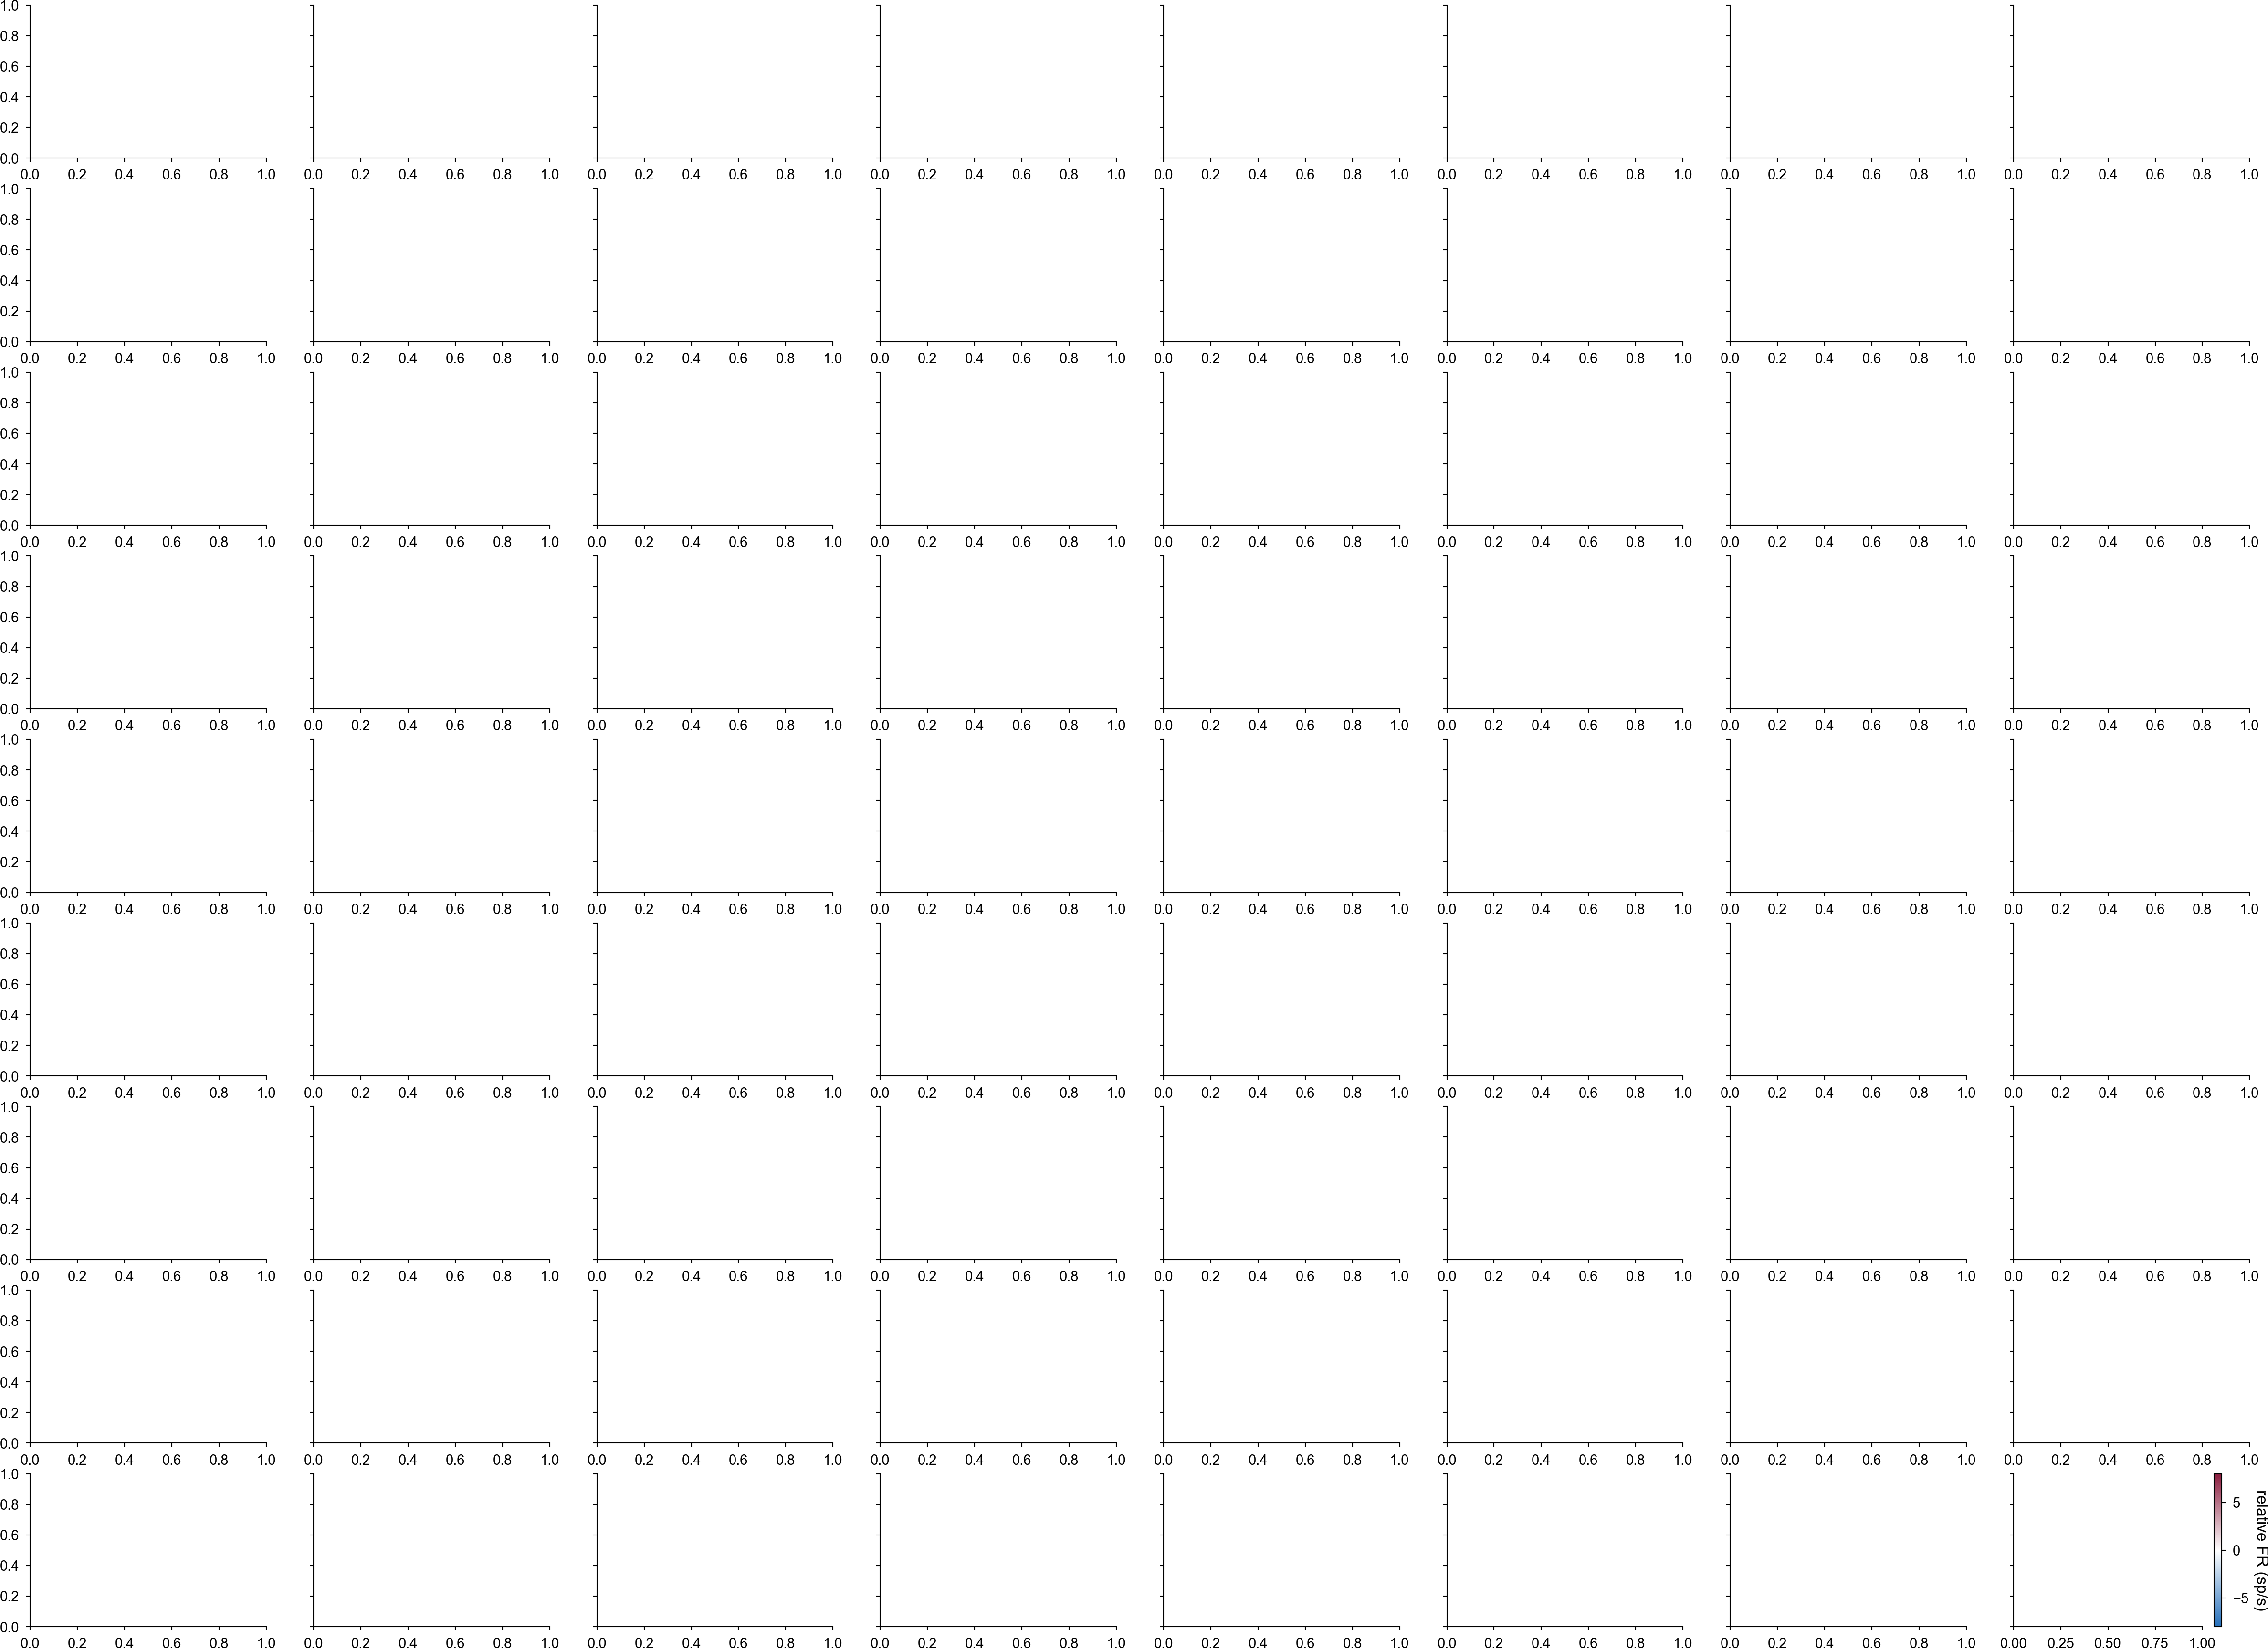

In [14]:
f, ax = plt.subplots(np.int(np.ceil(np.sqrt(len(chosen_trials)))),\
                     np.int(np.ceil(np.sqrt(len(chosen_trials))))-1, figsize=(20, 15), sharey=True)
cbar = plt.colorbar(im)
cbar.set_label('relative FR (sp/s)', rotation=270, verticalalignment='baseline')
#plt.savefig('./Figures/Figure2/COLORBARSupplementary_ManyTrial'+str(chosen_angle)+'.svg')
